Lane Detection
===
Execution of Lane Detection via Image Pre-processing and Information Extraction

In [3]:
import cv2
import os
import numpy as np
from copy import deepcopy

import sys
sys.path.append('../')

import general_utils
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [18, 6]

perspective_correction = None
perspective_correction_inv = None
perspective_trapezoid = None
warp_size = None
orig_size = None
left_fit_avg = None
right_fit_avg = None
MIN_DETECTIONS = 8
MAX_DETECTIONS = 10

def mathplot_display_concatenated(name, images, alignment="h"):
    if alignment == "v":
        images = cv2.vconcat(images) if isinstance(images, list) else images
    else:
        images = cv2.hconcat(images) if isinstance(images, list) else images
    
    plt.title(name)
    plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
    plt.figure()

    return images

Image Import
===
3 files in total (sd1, sd2, sd3)

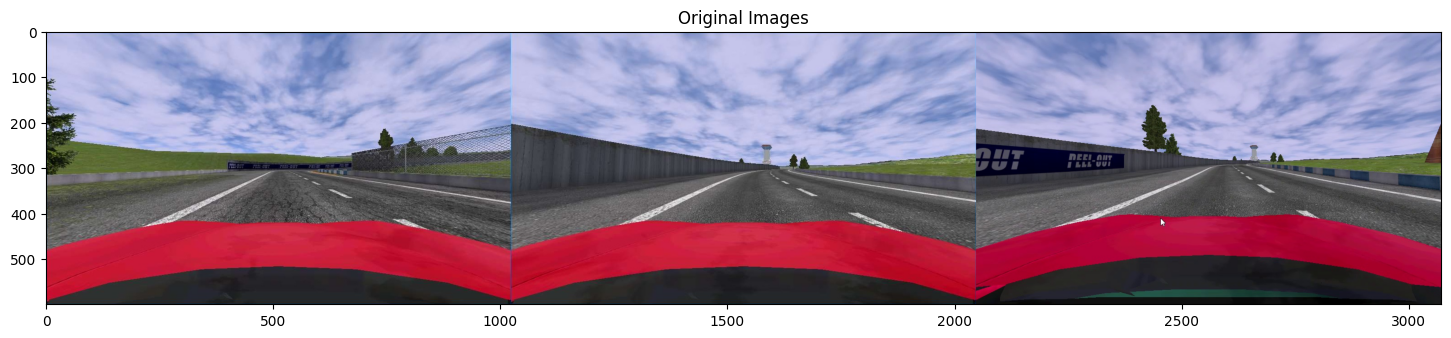

<Figure size 1800x600 with 0 Axes>

In [4]:
original_images = []
file_paths = ["road-images/sd1.jpg","road-images/sd2.jpg","road-images/sd3.jpg"]
for file_path in file_paths:
    original_images.append(cv2.imread(file_path))

print_ = mathplot_display_concatenated("Original Images", original_images, "h")

Color Space Testing
===
To Select best Color Space for Information Extraction

Perspective Warping
===
Perspective Correction for "Birds Eye View"